In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import ngmix
import galsim
import autometacal
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [84]:
# Genertate some data
def make_data(rng, noise, shear):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    psf_noise = 1.0e-6

    scale = 0.263

    psf_fwhm = 0.9
    gal_hlr = 0.5
    dy, dx = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(
        beta=2.5, fwhm=psf_fwhm,
    ).shear(
        g1=0.02,
        g2=-0.01,
    )

    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(
        dx=dx,
        dy=dy,
    )

    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale=scale).array

    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    im += rng.normal(scale=noise, size=im.shape)

    cen = (np.array(im.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    wt = im*0 + 1.0/noise**2
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )

    return obs

In [85]:
args={'seed':31415,
      'ntrial':1000,
      'noise': 1.0e-7,
      'psf': 'gauss'}
shear_true = [0.0, 0.00]
rng = np.random.RandomState(args['seed'])

In [86]:
obs = make_data(rng=rng, noise=args['noise'], shear=shear_true)

In [159]:
# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent

boot = ngmix.metacal.MetacalBootstrapper(
    runner=runner, psf_runner=psf_runner,
    rng=rng,
    psf=args['psf'],
    step=0.001,
    fixnoise=False
)

dlist = []

In [160]:
resdict, obsdict = boot.go(obs)

In [161]:
import tensorflow as tf
import galflow
zero_padding_factor=1
interp_factor=1

In [162]:
def drawKimage(images, 
               x_interpolant=tf.image.ResizeMethod.BICUBIC,
               interp_factor=2,
               zero_padding_factor=2):
  """
  Takes an input image (or a batch of images), 
  and turns it into a Fourier image using specified interpolant and 
  padding parameters
  """
  batch_size, Nx, Ny, Nc = images.get_shape().as_list()
  # For now, we only support square, even images, in only one band
  assert Nx == Ny
  assert Nx % 2 == 0
  assert Nc == 1

#     # First, we interpolate the image on a finer grid
#   if interp_factor > 1:
#     im = tf.image.resize(images,
#                         [Nx*interp_factor,
#                          Ny*interp_factor],
#                         method=x_interpolant)
#     # Since we lower the resolution of the image, we also scale the flux
#     # accordingly
#     images = im / interp_factor**2

#   # Second, we pad as necessary
#   im = tf.image.resize_with_crop_or_pad(images,
#                                        zero_padding_factor*Nx*interp_factor,
#                                        zero_padding_factor*Ny*interp_factor)

  im = images
  # Compute DFT
  return tf.signal.fft2d(tf.cast(im[...,0], tf.complex64))

In [163]:
i = pad(obs.image, [[22,22],[22,22]])
im = tf.convert_to_tensor(fftshift(i).reshape([1,88,88,1]), tf.float32)
imk = tf.signal.fftshift(drawKimage(im, interp_factor=interp_factor, zero_padding_factor=zero_padding_factor))
psf = tf.convert_to_tensor(obs.psf.image.reshape([1,38,38,1]), tf.float32)
psf = tf.image.resize_with_crop_or_pad((psf),88,88)
kpsf = tf.cast(tf.abs(drawKimage(psf, interp_factor=interp_factor, 
                                         zero_padding_factor=zero_padding_factor)), tf.complex64)
kpsf = tf.signal.fftshift(kpsf)

In [164]:
rpsf = obsdict['noshear'].psf.galsim_obj.drawImage(nx=88,ny=88, scale= 0.263).array
rpsf = tf.convert_to_tensor(rpsf.reshape([1,88,88,1]), tf.float32)
krpsf = tf.cast(tf.abs(drawKimage(rpsf, interp_factor=interp_factor, 
                                        zero_padding_factor=zero_padding_factor)), tf.complex64)
krpsf = tf.signal.fftshift(krpsf)

In [165]:
# compute mask in Fourier space 
fac = zero_padding_factor*interp_factor
kx, ky = meshgrid(fftfreq(88*fac), fftfreq(88*fac))
mask = sqrt(kx**2 + ky**2) <= 0.5
mask = fftshift(mask)

In [166]:
# Deconvolve obs by PSF
im_deconv = imk * ( (1./(kpsf+1e-15))*mask)

In [167]:
im_sheared = galflow.shear(tf.expand_dims(im_deconv,-1), 
                           atleast_1d(0.0), atleast_1d(0.0))[...,0]

In [168]:
def to_rfft(x):
    return tf.signal.fftshift(x)[:,:,:88*fac//2+1]

In [169]:
# Reconvolve obs by PSF
im_reconv = galflow.kconvolve(to_rfft(im_sheared), to_rfft(krpsf*mask), 
                              interp_factor=interp_factor, 
                              zero_padding_factor=2)
im_reconv = tf.signal.fftshift(im_reconv[...,0])[:,22:-22,22:-22]

Text(0.5, 0.98, '1p')

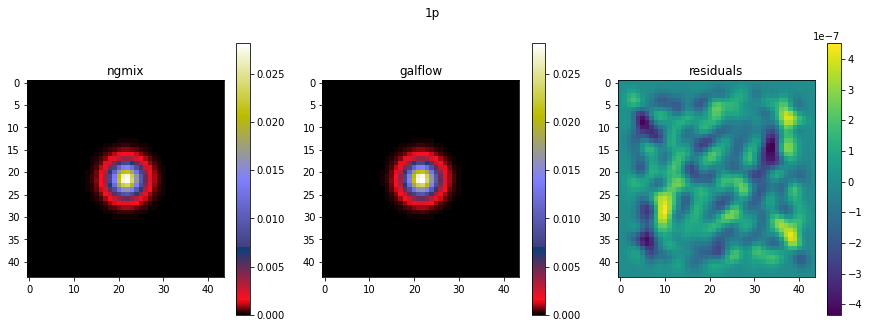

In [170]:
figure(figsize=[15,5])
subplot(131)
title('ngmix')
imshow(obsdict['1p'].image,cmap='gist_stern'); colorbar()
subplot(132)
imshow(im_reconv[0,:,:],cmap='gist_stern'); colorbar()
title('galflow')
subplot(133)
imshow(im_reconv[0,:,:] - obsdict['noshear'].image); colorbar()
title('residuals')
suptitle('1p')

In [173]:
im_sheared = galflow.shear(tf.expand_dims(im_deconv,-1), 
                           atleast_1d(0.001), atleast_1d(0.0))[...,0]
# Reconvolve obs by PSF
im_reconv = galflow.kconvolve(to_rfft(im_sheared), to_rfft(krpsf*mask), 
                              interp_factor=interp_factor, 
                              zero_padding_factor=2)
im_reconv = tf.signal.fftshift(im_reconv[...,0])[:,22:-22,22:-22]

Text(0.5, 0.98, '1p')

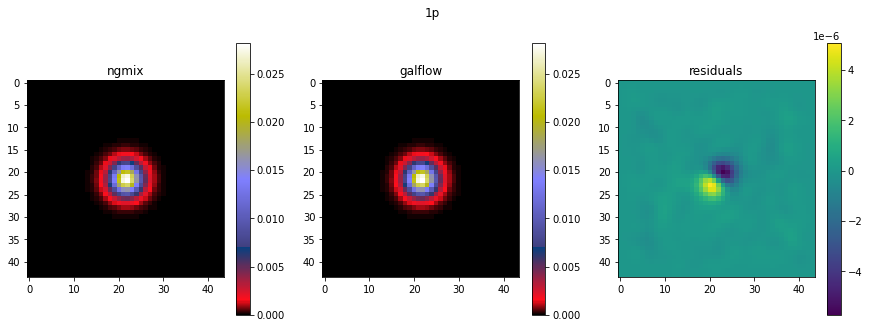

In [174]:
figure(figsize=[15,5])
subplot(131)
title('ngmix')
imshow(obsdict['1p'].image,cmap='gist_stern'); colorbar()
subplot(132)
imshow(im_reconv[0,:,:],cmap='gist_stern'); colorbar()
title('galflow')
subplot(133)
imshow(im_reconv[0,:,:] - obsdict['1p'].image); colorbar()
title('residuals')
suptitle('1p')

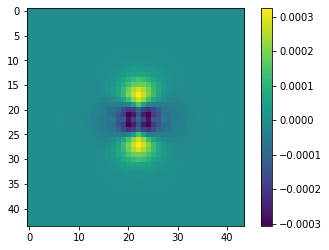

In [158]:
imshow(fftshift(real(fft2(fftshift(im_reconv[0,:,:])))) - fftshift(real(fft2(fftshift(obsdict['1p'].image))))); colorbar()

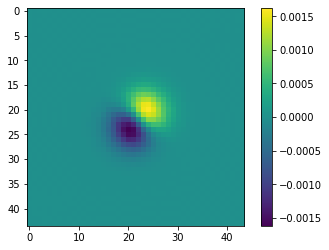

In [23]:
imshow(fftshift(imag(fft2(fftshift(im_reconv[0,:,:])))) - fftshift(imag(fft2(fftshift(obsdict['1p'].image))))); colorbar()